In [2]:
import pandas as pd
import matplotlib.pyplot as plt


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 971 entries, 2013-12-13 to 2017-10-20
Data columns (total 5 columns):
Soybean     971 non-null float64
Corn        971 non-null float64
CrudeOil    971 non-null float64
DXY         971 non-null float64
S&P500      971 non-null float64
dtypes: float64(5)
memory usage: 45.5 KB


In [3]:
data = pd.read_csv("../daily_data.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 971 entries, 2013-12-13 to 2017-10-20
Data columns (total 5 columns):
Soybean     971 non-null float64
Corn        971 non-null float64
CrudeOil    971 non-null float64
DXY         971 non-null float64
S&P500      971 non-null float64
dtypes: float64(5)
memory usage: 45.5 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5710397a20>,
      dtype=object)

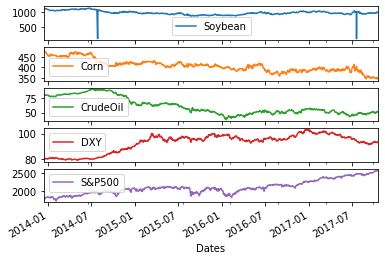

In [4]:
data['Dates'] = pd.to_datetime(data['Dates'])
data = data.set_index('Dates')

data.info()

data.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f571069f400>,
      dtype=object)

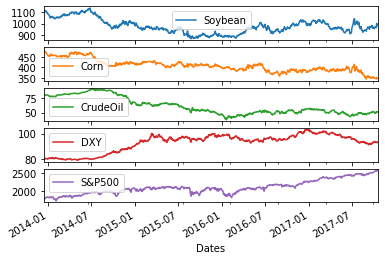

In [5]:
to_keep = data[data['Soybean']>500].index
value = data.loc[to_keep, 'Soybean'].mean()
data['Soybean'].loc[(data['Soybean']<500)] = pd.np.nan
data['Soybean'] = data['Soybean'].interpolate()

data.plot(subplots=True)

In [6]:
data.sort_index(inplace=True)
data.head()

,Soybean,Corn,CrudeOil,DXY,S&P500
Dates,,,,,
2013-12-13,1101.75,489.50,80.46,80.209999,1775.319946
2013-12-16,1106.50,479.25,80.78,80.070000,1786.540039
2013-12-17,1109.00,474.75,80.91,80.059998,1781.000000
2013-12-18,1103.75,474.50,80.25,80.110001,1810.650024
2013-12-19,1107.25,472.00,79.90,80.629997,1809.599976


In [7]:
returns = data.pct_change()

In [24]:
short_window = 7
long_window = 21

signals = pd.DataFrame(index=data.CrudeOil.index)
signals['signal'] = 0.0

signals['short_mavg'] = data.CrudeOil.rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = data.CrudeOil.rolling(window=long_window, min_periods=1, center=False).mean()

In [25]:
signals['signal'][short_window:] = pd.np.where(signals['short_mavg'][short_window:]
                                              > signals['long_mavg'][short_window:], 1.0, 0.0)

In [26]:
signals['positions'] = signals['signal'].diff()

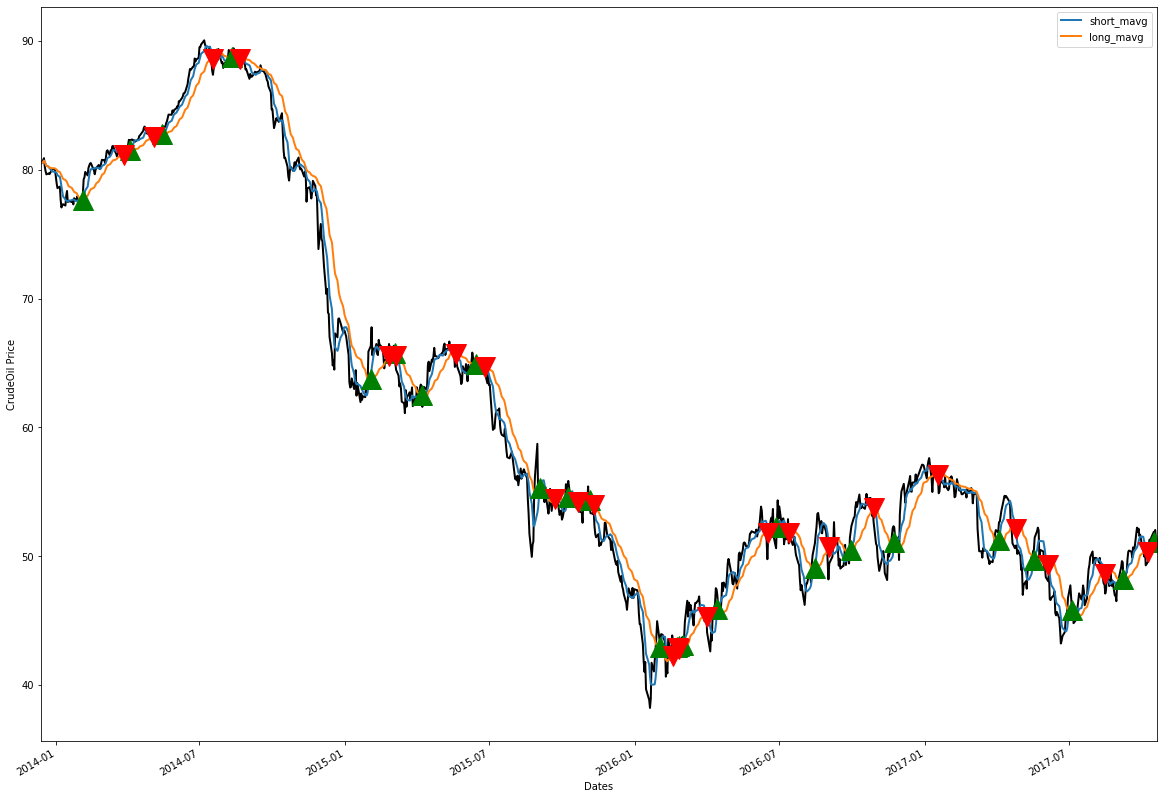

In [27]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111, ylabel='CrudeOil Price')
data.CrudeOil.plot(ax=ax1, color='black', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
ax1.plot(signals.loc[signals.positions == 1.0].index,
        signals.short_mavg[signals.positions == 1.0],
        '^', markersize = 20, color = 'g')
ax1.plot(signals.loc[signals.positions == -1.0].index,
        signals.short_mavg[signals.positions == -1.0],
        'v', markersize = 20, color = 'r')
plt.show()

In [31]:
initial_capital = float(100000)

positions = pd.DataFrame(index=signals.index).fillna(0.0)

positions['Position in $'] = 1000*signals['signal']

portfolio = positions.multiply(data.CrudeOil,axis=0)

pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(data.CrudeOil,axis=0)).sum(axis=1)

portfolio['cash'] = initial_capital - (pos_diff.multiply(data.CrudeOil,axis=0)).sum(axis=1).cumsum()

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

del portfolio['Position in $']

portfolio.tail(20)

,holdings,cash,total,returns
Dates,,,,
2017-09-25,52220.0,61880.0,114100.0,0.013862
2017-09-26,51880.0,61880.0,113760.0,-0.002980
2017-09-27,52140.0,61880.0,114020.0,0.002286
2017-09-28,51560.0,61880.0,113440.0,-0.005087
2017-09-29,51670.0,61880.0,113550.0,0.000970
2017-10-02,50580.0,61880.0,112460.0,-0.009599
2017-10-03,50420.0,61880.0,112300.0,-0.001423
2017-10-04,49980.0,61880.0,111860.0,-0.003918
2017-10-05,50790.0,61880.0,112670.0,0.007241


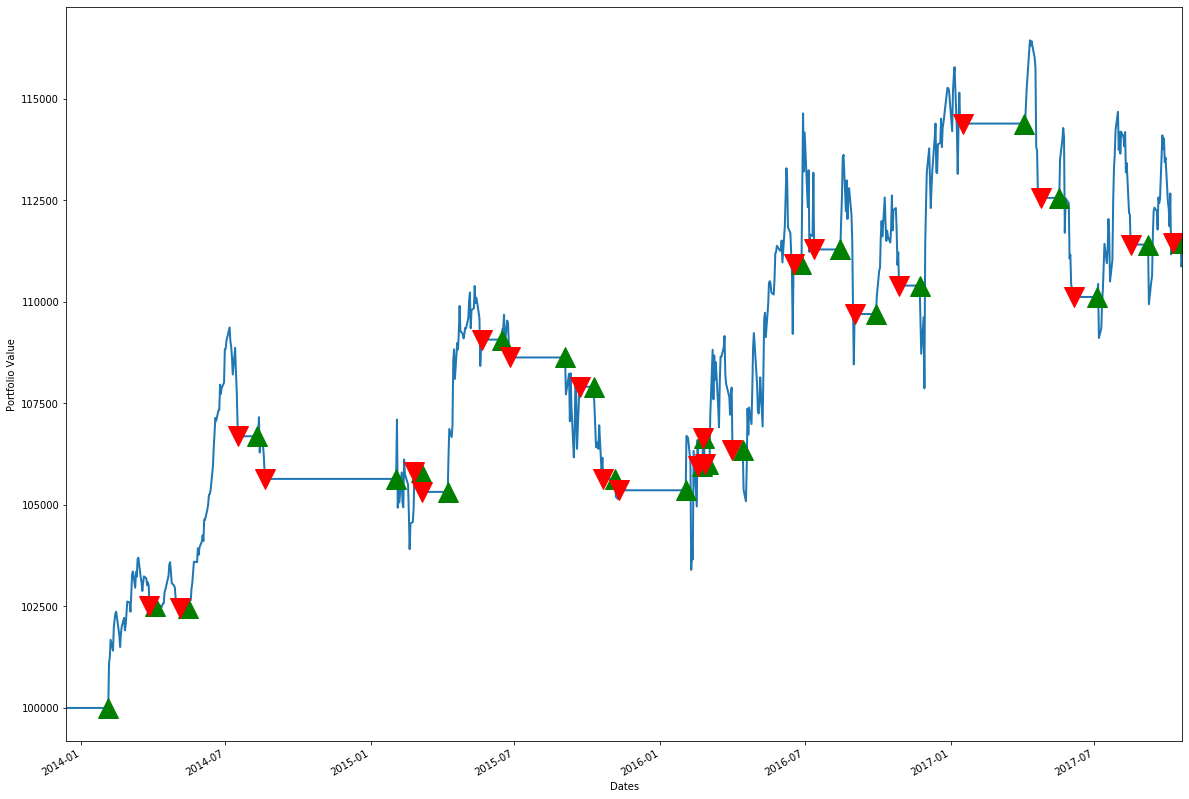

In [33]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(111, ylabel='Portfolio Value')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[signals.positions == 1.0].index,
        portfolio.total[signals.positions == 1.0],
        '^', markersize = 20, color = 'g')
ax1.plot(portfolio.loc[signals.positions == -1.0].index,
        portfolio.total[signals.positions == -1.0],
        'v', markersize = 20, color = 'r')
plt.show()

In [34]:
print("Portfolio total value")
print(portfolio.total.tail(1))

print("Absolute return")
print((((portfolio.total.tail(1)/float(100000))-float(1))*100))

Portfolio total value
Dates
2017-10-20    111050.0
Name: total, dtype: float64
Absolute return
Dates
2017-10-20    11.05
Name: total, dtype: float64
